### Install & import libraries

In [1]:
import sys
import os
import requests
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras_visualizer import visualizer
from IPython.display import display, Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

2024-07-30 14:44:33.399443: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 14:44:33.480734: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 14:44:33.535266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 14:44:33.590335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 14:44:33.604210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 14:44:33.696151: I tensorflow/core/platform/cpu_feature_gu

### Get utility code

In [2]:
url = 'https://raw.githubusercontent.com/BenCellini/wind-observer/main/util/utils.py'
r = requests.get(url)
with open('utils.py', 'w') as f:
    f.write(r.text)
f.close()

url = 'https://raw.githubusercontent.com/BenCellini/wind-observer/main/util/fly_plot_lib_plot.py'
r = requests.get(url)
with open('fly_plot_lib_plot.py', 'w') as f:
    f.write(r.text)
f.close()

url = 'https://raw.githubusercontent.com/BenCellini/wind-observer/main/util/figure_functions.py'
r = requests.get(url)
with open('figure_functions.py', 'w') as f:
    f.write(r.text)
f.close()

url = 'https://raw.githubusercontent.com/BenCellini/wind-observer/main/util/setdict.py'
r = requests.get(url)
with open('setdict.py', 'w') as f:
    f.write(r.text)
f.close()

url = 'https://raw.githubusercontent.com/BenCellini/wind-observer/main/simulator/mpc_fly.py'
r = requests.get(url)
with open('mpc_fly.py', 'w') as f:
    f.write(r.text)
f.close()

url = 'https://raw.githubusercontent.com/BenCellini/wind-observer/main/simulator/simulator_fly.py'
r = requests.get(url)
with open('simulator_fly.py', 'w') as f:
    f.write(r.text)
f.close()

# utility code
import utils
import figure_functions
import mpc_fly

/home/nehalmangat/.emacs.d/Projects/drosophila_body_orientation_predictor/.venv/lib/python3.10/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/nehalmangat/.emacs.d/Projects/drosophila_body_orientation_predictor/.venv/lib/python3.10/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


#### Import data

In [3]:
data_path = r"../ExperimentalData/combined_corrected_fly_trajectories_with_body_orientations.csv" # change this path
data = pd.read_csv(data_path)
data['heading_angle_x'] = np.cos(data['heading_angle'])
data['heading_angle_y'] = np.sin(data['heading_angle'])

In [4]:
data.head()

,trajec_objid,timestamp,position_x,position_y,velocity_x,velocity_y,airvelocity_x,airvelocity_y,wind_speed,eccentricity,ellipse_short_angle,groundspeed,groundspeed_angle,airspeed,airspeed_angle,thrust,thrust_angle,linear_acceleration,linear_acceleration_angle,heading_angle,angular_velocity,angular_acceleration,heading_angle_x,heading_angle_y
0,20130327_193200_17336,0.00,0.198190,0.005724,0.349395,0.092625,0.049395,0.092625,0.3,0.316778,-0.553696,0.361465,0.259141,0.104973,1.080880,5.236081e-08,2.883090,0.696049,-2.357952,-2.124493,103.376290,-1899.330525,-0.525835,-0.850587
1,20130327_193200_17336,0.01,0.201661,0.006627,0.344783,0.087979,0.044783,0.087979,0.3,0.421360,-0.711357,0.355830,0.249841,0.098721,1.099964,5.847233e-08,3.033591,0.698814,-2.359879,-2.282154,94.070677,-1828.230976,-0.652863,-0.757476
2,20130327_193200_17336,0.02,0.205085,0.007483,0.340014,0.083228,0.040014,0.083228,0.3,0.378154,-1.066600,0.350052,0.240057,0.092347,1.122640,6.624139e-08,-3.126163,0.702863,-2.362885,-2.637396,79.372191,-1713.733335,-0.875563,-0.483104
3,20130327_193200_17336,0.03,0.208461,0.008291,0.335091,0.078371,0.035091,0.078371,0.3,0.316603,-1.264121,0.344134,0.229751,0.085869,1.149811,7.499718e-08,-3.030048,0.706397,-2.366347,-2.834918,62.116338,-1571.565717,-0.953343,-0.301890
4,20130327_193200_17336,0.04,0.211787,0.009050,0.330013,0.073410,0.030013,0.073410,0.3,0.355797,-1.330672,0.338079,0.218883,0.079308,1.182696,8.386939e-08,-2.958731,0.706648,-2.369804,-2.901469,44.451404,-1406.492824,-0.971308,-0.237823


#### Pull out individual trajectories

In [5]:
traj_start = np.where(data.timestamp.values == 0.00)[0] # where trajectories start
n_traj = traj_start.shape[0] # number of trajectories
print(n_traj, 'trajectories')

4671 trajectories


In [6]:
traj_list = [] # list of individual trajectories
for n in range(n_traj):
    if n == (n_traj - 1):
        traj_end = data.shape[0]
    else:
        traj_end = traj_start[n + 1]

    traj = data.iloc[traj_start[n]:traj_end, :]
    if traj.shape[0] > 5:
        traj_list.append(traj)

#### Visualize individual trajectories

In [7]:
# implement my method / keep bens in comments in case

#### Input/Output Parameters

In [13]:
input_names = [
    'groundspeed',
    'groundspeed_angle',
    'airspeed',
    'airspeed_angle',
    'linear_acceleration',
    'linear_acceleration_angle',
    'thrust',
    'thrust_angle',
    'angular_velocity',
    'angular_acceleration',
    'wind_speed',
    'eccentricity'
]
output_names = ['heading_angle_x', 'heading_angle_y'] # change names here to predict heading angle

#### Augment data with time history

In [14]:
time_window = 4 # number of time-steps worth of memory

In [15]:
# Augment each trajectory separately & then combine all data
traj_augment_list = []
for traj in traj_list:
    traj_augment = utils.collect_offset_rows(traj,
                                             aug_column_names=input_names,
                                             keep_column_names=output_names,
                                             w=time_window,
                                             direction='backward')

    traj_augment_list.append(traj_augment)

traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

np.round(traj_augment_all, 4)

,groundspeed_0,groundspeed_1,groundspeed_2,groundspeed_3,groundspeed_angle_0,groundspeed_angle_1,groundspeed_angle_2,groundspeed_angle_3,airspeed_0,airspeed_1,airspeed_2,airspeed_3,airspeed_angle_0,airspeed_angle_1,airspeed_angle_2,airspeed_angle_3,linear_acceleration_0,linear_acceleration_1,linear_acceleration_2,linear_acceleration_3,linear_acceleration_angle_0,linear_acceleration_angle_1,linear_acceleration_angle_2,linear_acceleration_angle_3,thrust_0,thrust_1,thrust_2,thrust_3,thrust_angle_0,thrust_angle_1,thrust_angle_2,thrust_angle_3,angular_velocity_0,angular_velocity_1,angular_velocity_2,angular_velocity_3,angular_acceleration_0,angular_acceleration_1,angular_acceleration_2,angular_acceleration_3,wind_speed_0,wind_speed_1,wind_speed_2,wind_speed_3,eccentricity_0,eccentricity_1,eccentricity_2,eccentricity_3,heading_angle_x,heading_angle_y
0,0.3441,0.3501,0.3558,0.3615,0.2298,0.2401,0.2498,0.2591,0.0859,0.0923,0.0987,0.1050,1.1498,1.1226,1.1000,1.0809,0.7064,0.7029,0.6988,0.6960,-2.3663,-2.3629,-2.3599,-2.3580,0.0,0.0,0.0,0.0,-3.0300,-3.1262,3.0336,2.8831,62.1163,79.3722,94.0707,103.3763,-1571.5657,-1713.7333,-1828.2310,-1899.3305,0.3,0.3,0.3,0.3,0.3166,0.3782,0.4214,0.3168,-0.9533,-0.3019
1,0.3381,0.3441,0.3501,0.3558,0.2189,0.2298,0.2401,0.2498,0.0793,0.0859,0.0923,0.0987,1.1827,1.1498,1.1226,1.1000,0.7066,0.7064,0.7029,0.6988,-2.3698,-2.3663,-2.3629,-2.3599,0.0,0.0,0.0,0.0,-2.9587,-3.0300,-3.1262,3.0336,44.4514,62.1163,79.3722,94.0707,-1406.4928,-1571.5657,-1713.7333,-1828.2310,0.3,0.3,0.3,0.3,0.3558,0.3166,0.3782,0.4214,-0.9713,-0.2378
2,0.3319,0.3381,0.3441,0.3501,0.2074,0.2189,0.2298,0.2401,0.0727,0.0793,0.0859,0.0923,1.2230,1.1827,1.1498,1.1226,0.6999,0.7066,0.7064,0.7029,-2.3731,-2.3698,-2.3663,-2.3629,0.0,0.0,0.0,0.0,-2.9097,-2.9587,-3.0300,-3.1262,27.6507,44.4514,62.1163,79.3722,-1212.6262,-1406.4928,-1571.5657,-1713.7333,0.3,0.3,0.3,0.3,0.3750,0.3558,0.3166,0.3782,-0.9864,-0.1642
3,0.3256,0.3319,0.3381,0.3441,0.1953,0.2074,0.2189,0.2298,0.0661,0.0727,0.0793,0.0859,1.2730,1.2230,1.1827,1.1498,0.6821,0.6999,0.7066,0.7064,-2.3768,-2.3731,-2.3698,-2.3663,0.0,0.0,0.0,0.0,-2.8813,-2.9097,-2.9587,-3.0300,12.3466,27.6507,44.4514,62.1163,-983.4934,-1212.6262,-1406.4928,-1571.5657,0.3,0.3,0.3,0.3,0.6667,0.3750,0.3558,0.3166,-1.0000,0.0000
4,0.3191,0.3256,0.3319,0.3381,0.1824,0.1953,0.2074,0.2189,0.0595,0.0661,0.0727,0.0793,1.3361,1.2730,1.2230,1.1827,0.6511,0.6821,0.6999,0.7066,-2.3828,-2.3768,-2.3731,-2.3698,0.0,0.0,0.0,0.0,-2.8735,-2.8813,-2.9097,-2.9587,-0.8322,12.3466,27.6507,44.4514,-725.2544,-983.4934,-1212.6262,-1406.4928,0.3,0.3,0.3,0.3,0.5000,0.6667,0.3750,0.3558,-0.9999,0.0129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109496,0.5041,0.5119,0.5193,0.5264,2.9350,2.9313,2.9261,2.9211,0.8994,0.9070,0.9141,0.9209,3.0264,3.0235,3.0198,3.0162,0.7846,0.7956,0.8078,0.8195,-0.3102,-0.3171,-0.3096,-0.2864,0.0,0.0,0.0,0.0,3.0600,3.0580,3.0527,3.0448,-0.7867,-0.5417,-0.3135,-0.1252,-19.3640,-17.2254,-14.4952,-10.9801,0.4,0.4,0.4,0.4,0.2190,0.2610,0.3056,0.3437,-0.9913,0.1318
109497,0.4963,0.5041,0.5119,0.5193,2.9363,2.9350,2.9313,2.9261,0.8916,0.8994,0.9070,0.9141,3.0279,3.0264,3.0235,3.0198,0.7757,0.7846,0.7956,0.8078,-0.2926,-0.3102,-0.3171,-0.3096,0.0,0.0,0.0,0.0,3.0586,3.0600,3.0580,3.0527,-1.0280,-0.7867,-0.5417,-0.3135,-21.1238,-19.3640,-17.2254,-14.4952,0.4,0.4,0.4,0.4,0.3734,0.2190,0.2610,0.3056,-0.9935,0.1137
109498,0.4881,0.4963,0.5041,0.5119,2.9351,2.9363,2.9350,2.9313,0.8834,0.8916,0.8994,0.9070,3.0281,3.0279,3.0264,3.0235,0.7689,0.7757,0.7846,0.7956,-0.2697,-0.2926,-0.3102,-0.3171,0.0,0.0,0.0,0.0,3.0550,3.0586,3.0600,3.0580,-1.2490,-1.0280,-0.7867,-0.5417,-22.6255,-21.1238,-19.3640,-17.2254,0.4,0.4,0.4,0.4,0.3322,0.3734,0.2190,0.2610,-0.9936,0.1134
109499,0.4797,0.4881,0.4963,0.5041,2.9314,2.9351,2.9363,2.9350,0.8749,0.8834,0.8916,0.8994,3.0270,3.0281,3

#### Number of inputs/outputs

In [16]:
n_input = len(input_names) * time_window
n_output = len(output_names)

print('Inputs:', n_input)
print('Output:', n_output)

Inputs: 48
Output: 2


In [17]:
# Input data
X = traj_augment_all.iloc[:, 0:n_input]
# Output data
Y = traj_augment_all.iloc[:, n_input:]

#### Define model function

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
def create_model(neurons=50, layers=1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=n_input, activation='relu'))
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
    model.add(Dense(n_output, activation='linear'))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model

In [19]:
clf = KerasRegressor(model=create_model,epochs=150, batch_size=256,validation_split=0.2,layers=1,neurons=20,verbose=0)

In [20]:
# Define hyperparameters to search
param_grid = {
    'neurons': [20, 50, 100],   # Number of neurons
    'layers': [1, 2, 3]         # Number of layers
}

In [21]:
import sklearn
from sklearn.model_selection import GridSearchCV

In [22]:
# Set up the grid search
grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

2024-07-30 14:48:13.943642: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 14:48:13.953846: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 14:48:13.977272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 14:48:14.004646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 14:48:14.011666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 14:48:14.025882: I tensorflow/core/platform/cpu_feature_gu

In [23]:
grid_result.param_grid

{'neurons': [20, 50, 100], 'layers': [1, 2, 3]}

In [24]:
# Create a DataFrame with the grid search results
df_results = pd.DataFrame(grid_result.cv_results_)

# Print out important columns
print(df_results[['param_layers', 'param_neurons', 'mean_test_score', 'std_test_score', 'rank_test_score']])


   param_layers  param_neurons  mean_test_score  std_test_score  \
0             1             20        -0.935997        0.591812   
1             1             50        -0.737752        0.476431   
2             1            100        -0.697624        0.356512   
3             2             20        -0.261405        0.022548   
4             2             50        -0.234289        0.021287   
5             2            100        -0.234452        0.035534   
6             3             20        -0.239309        0.017408   
7             3             50        -0.245196        0.028720   
8             3            100        -0.237946        0.036999   

   rank_test_score  
0                9  
1                8  
2                7  
3                6  
4                1  
5                2  
6                4  
7                5  
8                3  


In [25]:
history = grid_result.best_estimator_.history_

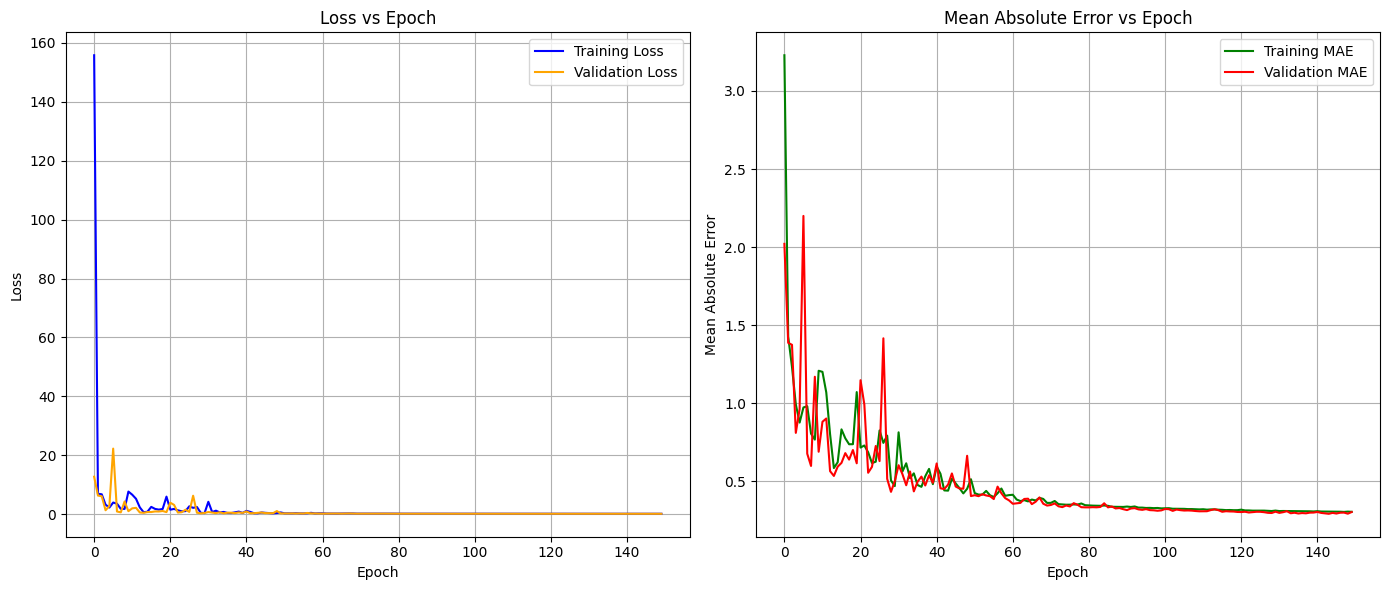

In [26]:
# Create a new figure
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history['mean_absolute_error'], label='Training MAE', color='green')
plt.plot(history['val_mean_absolute_error'], label='Validation MAE', color='red')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs Epoch')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [27]:
Y_predict = grid_result.best_estimator_.predict(X,batch_size=4096)

In [28]:
zeta_predict = np.arctan2(Y_predict[:, 1], Y_predict[:, 0])
zeta_true = np.arctan2(Y.values[:, 1], Y.values[:, 0])

In [29]:
# Circular distance function
def circular_distance(a, b):
  delta = np.arctan((np.tan(a) - np.tan(b)) / (1 + np.tan(a) * np.tan(b)))
  return delta

In [30]:
zeta_error = circular_distance(zeta_predict, zeta_true) # caculate error
zeta_mean_error = scipy.stats.circmean(zeta_error, high=np.pi, low=-np.pi) # caculate circular mean
zeta_std_error = scipy.stats.circstd(zeta_error, high=np.pi, low=-np.pi) # caculate circular standard deviation
print('mean error:', np.round(np.rad2deg(zeta_mean_error), 4), 'deg')
print('mean std:', np.round(np.rad2deg(zeta_std_error), 4), 'deg')

mean error: -0.1148 deg
mean std: 28.1337 deg


Text(0, 0.5, 'Count')

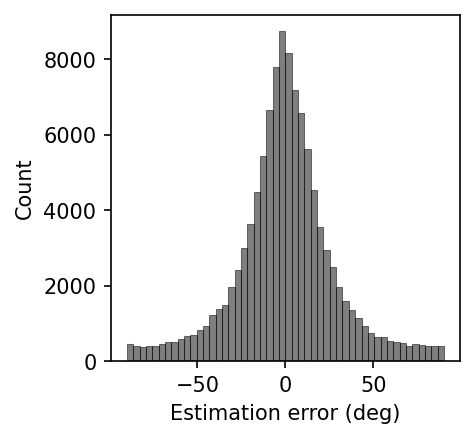

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
hist_data = ax.hist(np.rad2deg(zeta_error), bins=50, facecolor='black', alpha=0.5, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Estimation error (deg)')
ax.set_ylabel('Count')

Text(0.5, 0, 'True Heading (rad)')

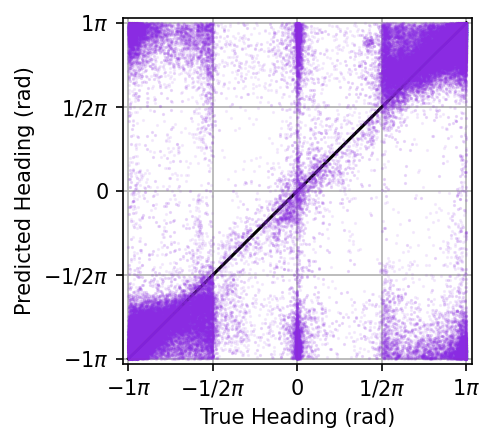

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)

zeta_line = np.arange(-np.pi, 1.01*np.pi, np.pi/2)

ax.plot(zeta_line, zeta_line, '-', color='black')
ax.plot(zeta_true, zeta_predict, '.', markersize=1, alpha=0.1, color='blueviolet')

figure_functions.pi_yaxis(ax)
figure_functions.pi_xaxis(ax)
ax.grid()

ax.set_ylim(-np.pi - 0.1, np.pi + 0.1)
ax.set_xlim(-np.pi - 0.1, np.pi + 0.1)

ax.set_ylabel('Predicted Heading (rad)')
ax.set_xlabel('True Heading (rad)')